# Project report: Affects of weather phenomenas on renewable energy production

This project aims to investigate the impact of climate on a power grid that relies more and more on wind/solar energy, as is the case in Germany.

## Outline

1. Introduction
2. Install & import dependencies
3. Load & process data
4. Answering questions
5. Conclusion

## 1. Introduction

### Rational

Analyzing the relationship between climate data and renewable energy generation is important for understanding the reliability of such sources.
The results of this analysis could help readers make data-informed decisions about renewable energy and its use.
Ideally, this analysis can make a small contribution to the transition to sustainable and efficient energy systems, which is critical to reducing carbon emissions and mitigating climate change.

### Questions answered in this project

1. Is there a correlation between weather conditions and renewable energy production, and if so, is it linear or exponential?
2. How reliable are renewable energy sources? Do extreme weather conditions affect grid stability?
3. What is the potential for energy storage during peak production periods?
4. What is the trend for renewable energy generation in Germany?

### Datasources

#### Datasource 1: DWD Climate Data
* Metadata URL: https://mobilithek.info/offers/-4979349128225020802
* Data URL: https://opendata.dwd.de/climate
* Data Type: various

This dataset contains meteorological measurements and observations.

#### Datasource 2: Open Power System Data
* Metadata URL: https://data.open-power-system-data.org/time_series/2020-10-06
* Data URL: https://data.open-power-system-data.org/time_series/opsd-time_series-2020-10-06.zip
* Data Type: csv

This dataset contains hourly timeseries data about electricity consumption, wind and solar power generation and capacities, aggregated by country, control area, or bidding zone from 2015-mid 2020.

## 2. Install dependencies

A working Python installation is prerequisite for this project. The following dependencies are required to run this Jupyter notebook. They can be installed using the following commands:

In [1]:
%%capture

%pip install "SQLAlchemy==1.4.46"
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn

## 3. Load & process data

Before we can begin answering key questions we first need to load the data from the database and process it so that it can be used for analysis and visualization.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATABASE_FILE: str = "sqlite:///../data/processed_data/transformed_data.sqlite"

In [4]:
#
# Power data
#

power_df = pd.read_sql_table("power_data", DATABASE_FILE)

# Remove hours and minutes from the column as we are only interested in the date
power_df["cet_cest_timestamp"] = power_df["cet_cest_timestamp"].dt.date

# Group by date and calculate the mean, so we get the power for Germany for each day (instead of hourly)
power_df = power_df.groupby("cet_cest_timestamp").mean().reset_index()

#
# Temperature data
#

temperature_df = pd.read_sql_table("temperature_data", DATABASE_FILE)

# Replace illegal values with NA
temperature_df.replace(-999, pd.NA, inplace=True)

# Remove hours and minutes from the column as we are only interested in the date
temperature_df["date"] = temperature_df["date"].dt.date

# Group by date and calculate the average temperature in Germany
temperature_df = temperature_df.groupby("date")[["temperature", "humidity"]].mean().reset_index()

#
# Rain data
#

rain_df = pd.read_sql_table("rain_data", DATABASE_FILE)

# Replace illegal values with NA
rain_df.replace(-999, pd.NA, inplace=True)

# Remove hours and minutes from data -> we are only interested in the day
rain_df["date"] = rain_df["date"].dt.date

# Remove bad data
drop_codes = {
    4: pd.NA,  # Form of precipitation not known, although precipitation reported
    9: pd.NA,  # Misidentification; missing value or precipitation form not detectable with automatic measurement
}
rain_df["rain_form"] = rain_df["rain_form"].replace(drop_codes)

# Aggregate data
def mode_without_zero(x):
    x = x[x != 0]
    return x.mode() if not x.empty else pd.NA

aggregations = {
    "rain": "mean",
    "rain_form": mode_without_zero,
    "snow_height": "mean",
    "new_snow_height": "mean",
}

# Group by date and calculate the average precipitation
rain_df = rain_df.groupby("date").agg(aggregations).reset_index()

#
# Cloud data
#

cloud_df = pd.read_sql_table("cloud_data", DATABASE_FILE)

# Replace illegal values with NA
cloud_df.replace(-999, pd.NA, inplace=True)

# Remove hours and minutes from data -> we are only interested in the day
cloud_df["date"] = cloud_df["date"].dt.date

# Group by date and calculate the average of the cloud cover
cloud_df = cloud_df.groupby("date")[["cloud_cover"]].mean().reset_index()

#
# Wind data
#

wind_df = pd.read_sql_table("wind_data", DATABASE_FILE)

# Replace illegal values with NA
wind_df.replace(-999, pd.NA, inplace=True)

# Remove hours and minutes from data as we are only interested in the day
wind_df["date"] = wind_df["date"].dt.date

# Group by date and calculate the average wind speed in Germany
wind_df = wind_df.groupby("date")[["speed"]].mean().reset_index()

The heavy lifting is now done, the data is now in a format that is easy to work with and will be used at multiple points in the analysis.

## 4. Answering questions

### Question 1. Is there a correlation between weather conditions and renewable energy production, and if so, is it linear or exponential?

To answer this initial question, I will use scatter plots to visualize the correlation between two variables.
The first variable is the amount of energy produced by renewable sources, and the second is a weather condition / phenomenon.
A scatter plot can easily show us if there is a correlation between these two variables, and if so, what kind of correlation it is.

#### Temperature

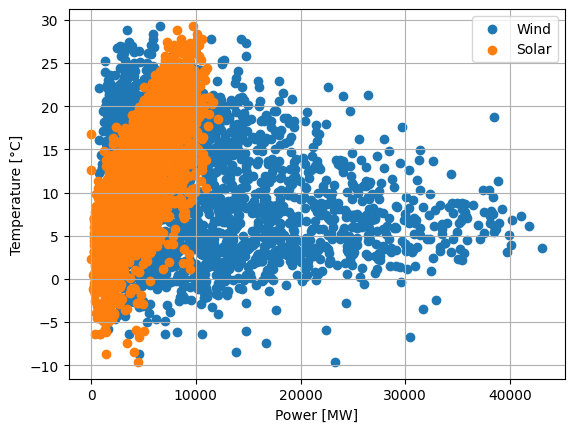

In [5]:
# Drop bad entries
local_power_df = power_df[power_df["cet_cest_timestamp"].isin(temperature_df["date"])]
local_temperature_df = temperature_df[temperature_df["date"].isin(local_power_df["cet_cest_timestamp"])]

# Plot
plt.scatter(local_power_df["DE_wind_generation_actual"], local_temperature_df["temperature"], label="Wind")
plt.scatter(local_power_df["DE_solar_generation_actual"], local_temperature_df["temperature"], label="Solar")
plt.xlabel("Power [MW]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)
plt.show()

This scatter plot shows us that there is a correlation between the temperature and the amount of energy produced by renewable sources. There is a linear correlation between the temperature and the amount of energy produced by solar panels. The warmer it is, the more energy is produced. The correlation between the temperature and the amount of energy produced by wind turbines is not as straight forward. The plot allows us to see that there is a corridor of temperatures in which the wind turbines produce the most energy. If it is too cold or too warm, the amount of energy produced by wind turbines decreases. The optimal temperature seems to be around 5-10°C. This is probably due to the wind being at its highest at these temperatures. This correlation is shown in a section below (interesting findings).

#### Precipitation

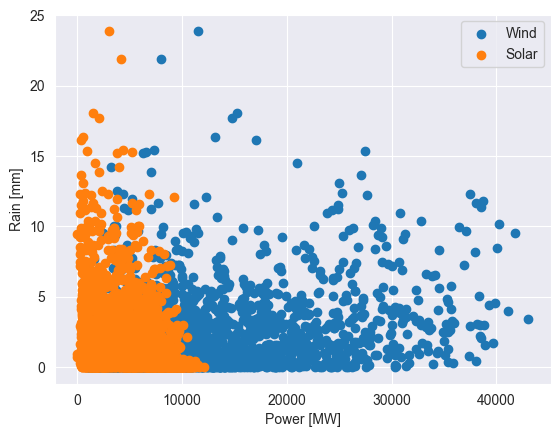

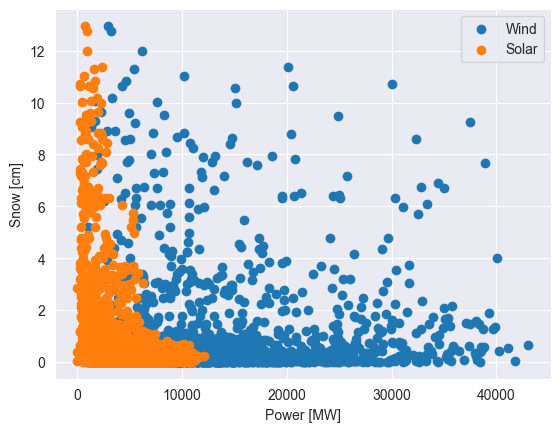

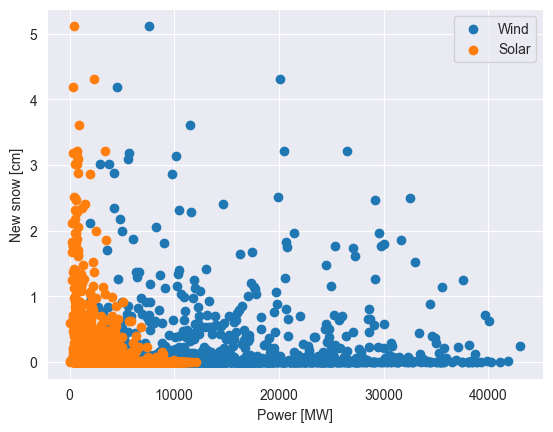

In [33]:
# Drop bad entries
local_power_df = power_df[power_df["cet_cest_timestamp"].isin(rain_df["date"])]
local_rain_df = rain_df[rain_df["date"].isin(local_power_df["cet_cest_timestamp"])]

# Plot
plt.scatter(local_power_df["DE_wind_generation_actual"], local_rain_df["rain"], label="Wind")
plt.scatter(local_power_df["DE_solar_generation_actual"], local_rain_df["rain"], label="Solar")
plt.xlabel("Power [MW]")
plt.ylabel("Rain [mm]")
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(local_power_df["DE_wind_generation_actual"], local_rain_df["snow_height"], label="Wind")
plt.scatter(local_power_df["DE_solar_generation_actual"], local_rain_df["snow_height"], label="Solar")
plt.xlabel("Power [MW]")
plt.ylabel("Snow [cm]")
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(local_power_df["DE_wind_generation_actual"], local_rain_df["new_snow_height"], label="Wind")
plt.scatter(local_power_df["DE_solar_generation_actual"], local_rain_df["new_snow_height"], label="Solar")
plt.xlabel("Power [MW]")
plt.ylabel("New snow [cm]")
plt.legend()
plt.grid(True)
plt.show()

Precipitation strongly affects solar energy production. This is due to the fact that solar panels rely on sun-light to produce electrical power which is hemmed by clouds, rain and snow. The more precipitation the less energy is produced. Wind turbines are not affected by rain or snow.

#### Cloud coverage

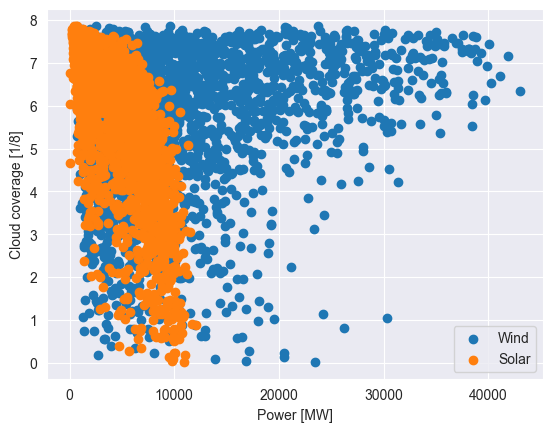

In [34]:
# Drop bad entries
local_power_df = power_df[power_df["cet_cest_timestamp"].isin(cloud_df["date"])]
local_cloud_df = cloud_df[cloud_df["date"].isin(local_power_df["cet_cest_timestamp"])]

# Plot
plt.scatter(local_power_df["DE_wind_generation_actual"], local_cloud_df["cloud_cover"], label="Wind")
plt.scatter(local_power_df["DE_solar_generation_actual"], local_cloud_df["cloud_cover"], label="Solar")
plt.xlabel("Power [MW]")
plt.ylabel("Cloud coverage [1/8]")
plt.legend()
plt.grid(True)
plt.show()

As explained in the section above, solar panels rely on sun-light to produce electrical power. Clouds block, reflect or absorb this light which reduces the amount of light reaching solar panels. This is why there is a strong correlation between cloud coverage and solar energy production. The higher the cloud coverage the less solar energy is produced linearly. Wind turbines are also affected by cloud coverage as they benefit from the wind being stronger when there are clouds. This is also shown in a section below (interesting findings). The more clouds the more wind energy is produced and vice versa.

#### Wind speed

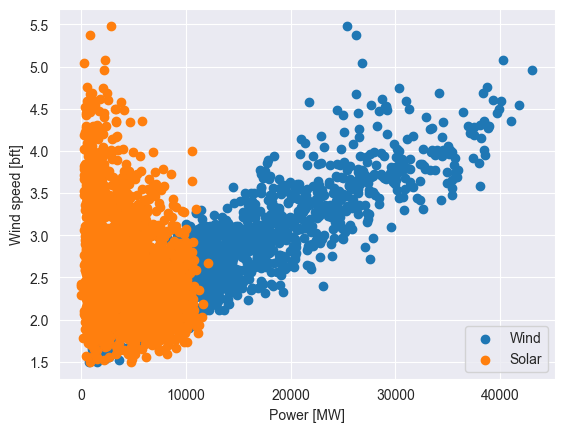

In [35]:
# Drop bad entries
local_power_df = power_df[power_df["cet_cest_timestamp"].isin(wind_df["date"])]
local_wind_df = wind_df[wind_df["date"].isin(local_power_df["cet_cest_timestamp"])]

# Plot
plt.scatter(local_power_df["DE_wind_generation_actual"], local_wind_df["speed"], label="Wind")
plt.scatter(local_power_df["DE_solar_generation_actual"], local_wind_df["speed"], label="Solar")
plt.xlabel("Power [MW]")
plt.ylabel("Wind speed [bft]")
plt.legend()

# # Linear regression
# x = local_power_df["DE_wind_generation_actual"]
# y = local_wind_df["speed"]
# m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x + b, color="red", label="Linear regression")

plt.grid(True)
plt.show()

Wind speeds strongly affect wind production. The stronger the wind the more energy is produced. Solar panels are not affected by wind speeds but rather by cloud coverage. Solar panels are therefore indirectly affected by wind speeds.

#### Interesting findings

Cloud coverage and wind speed have a linear correlation. One could say one follows the other.

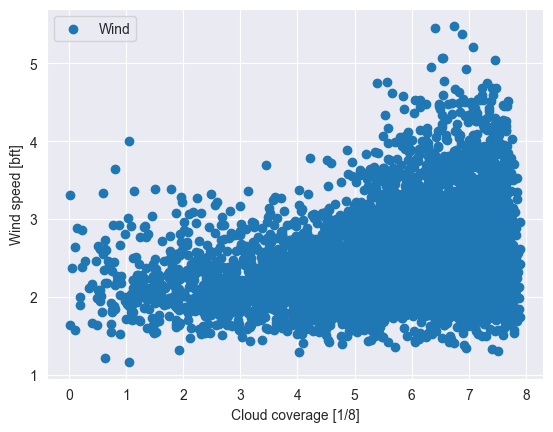

In [38]:
# Drop bad entries
cloud_df = cloud_df[cloud_df["date"].isin(wind_df["date"])]
wind_df = wind_df[wind_df["date"].isin(cloud_df["date"])]

# Plot
plt.scatter(cloud_df["cloud_cover"], wind_df["speed"])
plt.xlabel("Cloud coverage [1/8]")
plt.ylabel("Wind speed [bft]")
plt.grid(True)
plt.show()

Wind and temperature also have a zone of maximum concentration. This is due to the fact that wind is caused by temperature differences. The bigger the difference the stronger the wind. The strongest wind speeds can be observed between 0 and 10 degrees Celsius. This is also the temperature range where the most energy is produced by wind turbines (in a section above).

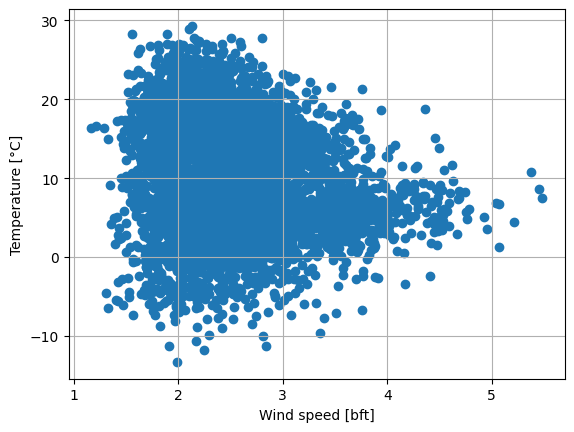

In [6]:
# Drop bad entries
wind_df = wind_df[wind_df["date"].isin(temperature_df["date"])]
temperature_df = temperature_df[temperature_df["date"].isin(wind_df["date"])]

# Plot
plt.scatter(wind_df["speed"], temperature_df["temperature"])
plt.xlabel("Wind speed [bft]")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.show()

### Question 2. How reliable are renewable energy sources? Do extreme weather conditions affect grid stability?

The reliability of energy sources is important to guarantee a stable electrical grid. If massive amounts of energy spontaneously disappear from the grid, the grid will become unstable and blackouts will occur. Fossil fuels are very reliable energy sources. They can be used at any time and are not dependent on weather conditions but these plants take a long time to start up and shut down. This is why it is important to know how reliable renewable energy sources are. This section is dedicated to answering this question.

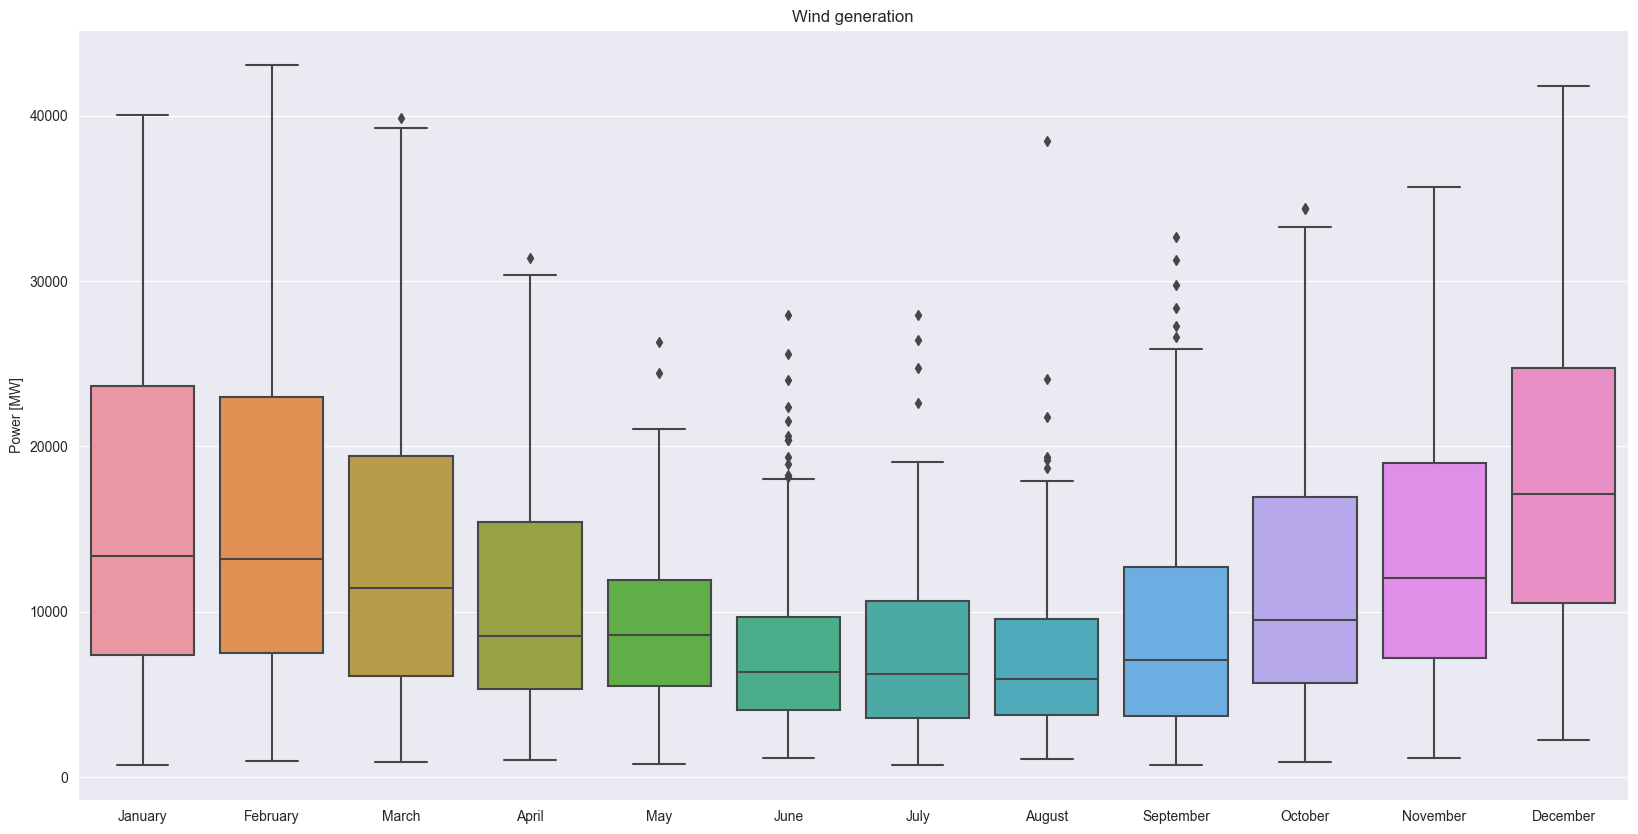

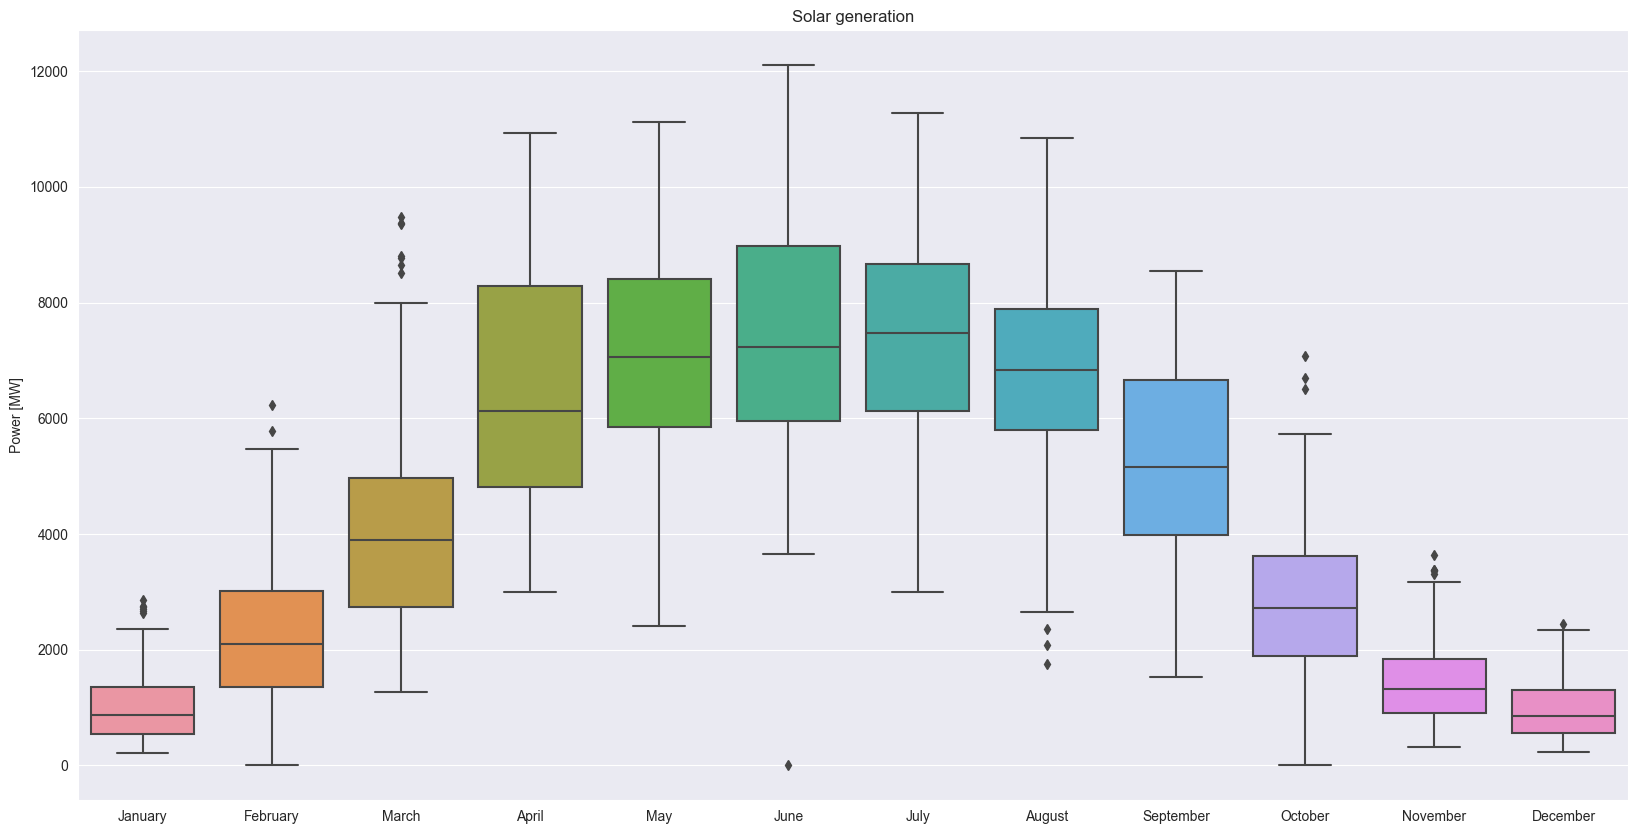

In [23]:
# Make local copies of the dataframes
local_power_df = power_df.copy()

# Convert the "cet_cest_timestamp" column to datetime if it's not already
power_df["cet_cest_timestamp"] = pd.to_datetime(power_df["cet_cest_timestamp"])

# Month mapping
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

month_dataframes = []

# Split the dataframe into months
for month in range(1, 13):
    month_dataframes.append(power_df[power_df["cet_cest_timestamp"].dt.month == month])

# Plot
plt.figure(figsize=(20, 10))
the_plot = sns.boxplot(data=[month_dataframes[0]["DE_wind_generation_actual"],
                             month_dataframes[1]["DE_wind_generation_actual"],
                             month_dataframes[2]["DE_wind_generation_actual"],
                             month_dataframes[3]["DE_wind_generation_actual"],
                             month_dataframes[4]["DE_wind_generation_actual"],
                             month_dataframes[5]["DE_wind_generation_actual"],
                             month_dataframes[6]["DE_wind_generation_actual"],
                             month_dataframes[7]["DE_wind_generation_actual"],
                             month_dataframes[8]["DE_wind_generation_actual"],
                             month_dataframes[9]["DE_wind_generation_actual"],
                             month_dataframes[10]["DE_wind_generation_actual"],
                             month_dataframes[11]["DE_wind_generation_actual"]])
the_plot.set_xticklabels(months)
plt.title("Wind generation")
plt.ylabel("Power [MW]")
plt.show()

plt.figure(figsize=(20, 10))
the_plot = sns.boxplot(data=[month_dataframes[0]["DE_solar_generation_actual"],
                             month_dataframes[1]["DE_solar_generation_actual"],
                             month_dataframes[2]["DE_solar_generation_actual"],
                             month_dataframes[3]["DE_solar_generation_actual"],
                             month_dataframes[4]["DE_solar_generation_actual"],
                             month_dataframes[5]["DE_solar_generation_actual"],
                             month_dataframes[6]["DE_solar_generation_actual"],
                             month_dataframes[7]["DE_solar_generation_actual"],
                             month_dataframes[8]["DE_solar_generation_actual"],
                             month_dataframes[9]["DE_solar_generation_actual"],
                             month_dataframes[10]["DE_solar_generation_actual"],
                             month_dataframes[11]["DE_solar_generation_actual"]])
the_plot.set_xticklabels(months)
plt.title("Solar generation")
plt.ylabel("Power [MW]")
plt.show()

Generally solar and wind energy production follows a yearly trend. Trends are important for grid providers to know when to expect more or less energy production. This is key information as to when to start up or shut down fossil fuel plants. The more energy is produced by renewable energy sources the less fossil fuels are needed.

Both energy production types follow a curve pattern and are loosely inverse to another when plotted on a yearly graph.
The most solar energy is produced in the summer months and the least in the winter months. Wind energy production accelerates in the winter months.

There are only a handful of events where energy production massively varies from the norm.

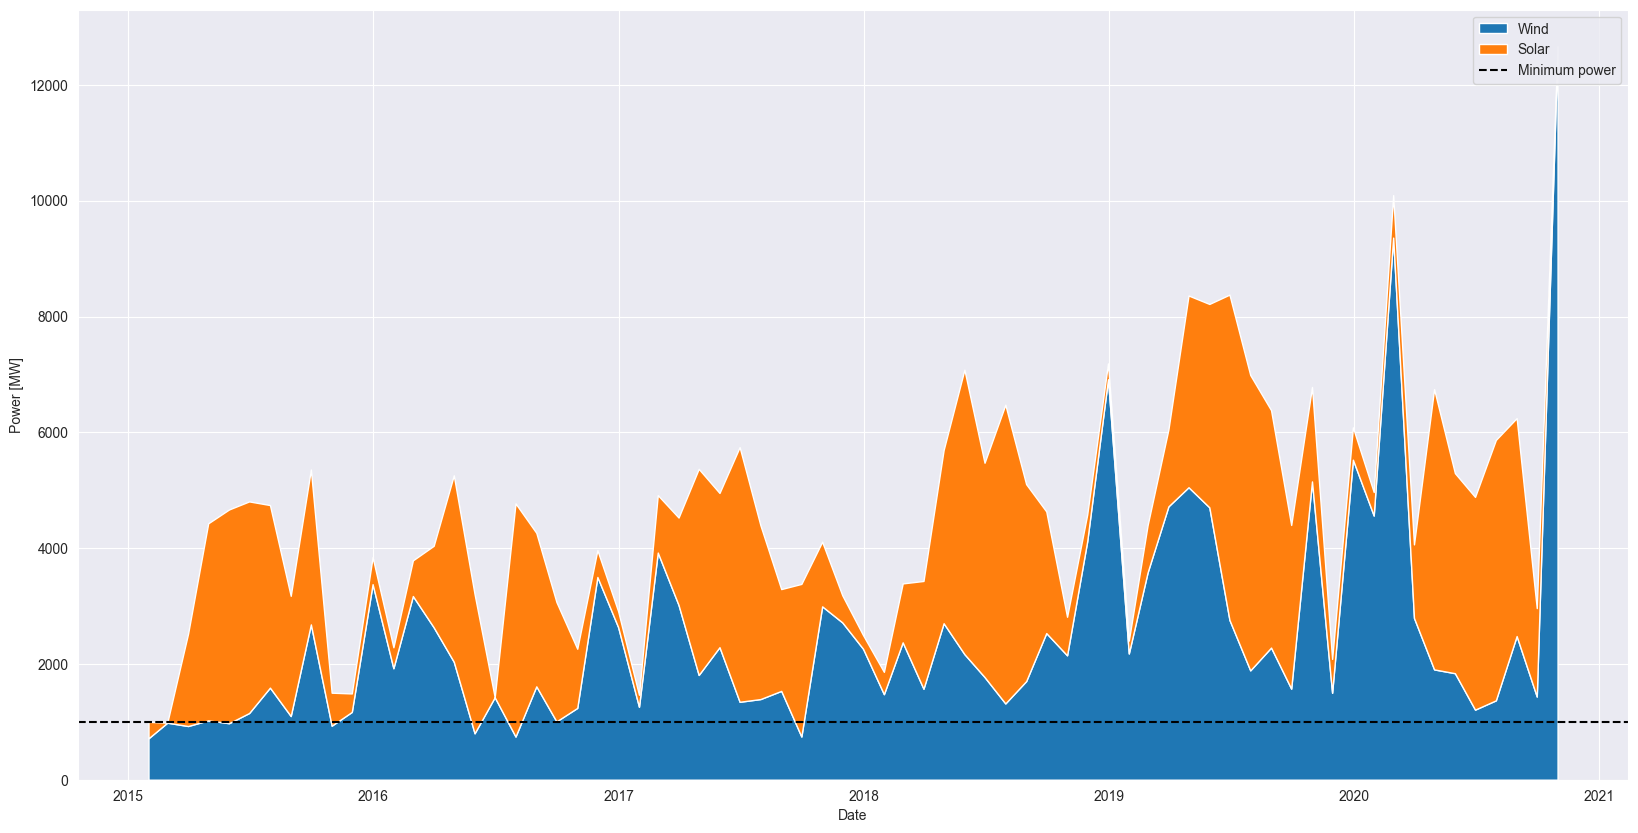

Minimum power: 999.7916666666666 MW
Date: 2015-01-31 00:00:00


In [24]:
# Make local copies of the dataframes
local_power_df = power_df.copy()

# Convert the "cet_cest_timestamp" column to a datetime object if it's not already
local_power_df["cet_cest_timestamp"] = pd.to_datetime(local_power_df["cet_cest_timestamp"])

# We want to group the data by month and aggregate the minimum value per month for wind and solar
min_wind_df = local_power_df.groupby(pd.Grouper(key="cet_cest_timestamp", freq="M"))["DE_wind_generation_actual"].min()
min_solar_df = local_power_df.groupby(pd.Grouper(key="cet_cest_timestamp", freq="M"))["DE_solar_generation_actual"].min()

# Plot a stacked area chart with solar and wind power
plt.figure(figsize=(20, 10))
plt.stackplot(min_wind_df.index, min_wind_df, min_solar_df, labels=["Wind", "Solar"])
plt.xlabel("Date")
plt.ylabel("Power [MW]")

# Create a horizontal line for the minimum power (sum of solar and wind) and include the value in the legend
min_power = min_wind_df + min_solar_df
plt.axhline(min_power[0], color="black", linestyle="--", label="Minimum power")

# Include a legend
plt.legend()
plt.show()

# Print the minimum power and the date it occurred
print("Minimum power: {} MW".format(min_power[0]))
print("Date: {}".format(min_power.index[0]))

In this stacked area chart of the minimum energy production for every month we can see that energy production is usually very high but can drop to very low values spontaneously. The lowest recorded energy production in the dataset was on the 31st of January 2015 with roughly 1 GW of energy production from solar and wind combined. Grid providers need to be prepared for days such as these and have enough fossil fuel plants running to cover the energy demand.

#### Orkan Sabine

Wind power: 34538.041666666664 MW
Solar power: 3328.6666666666665 MW
Total power: 37866.70833333333 MW


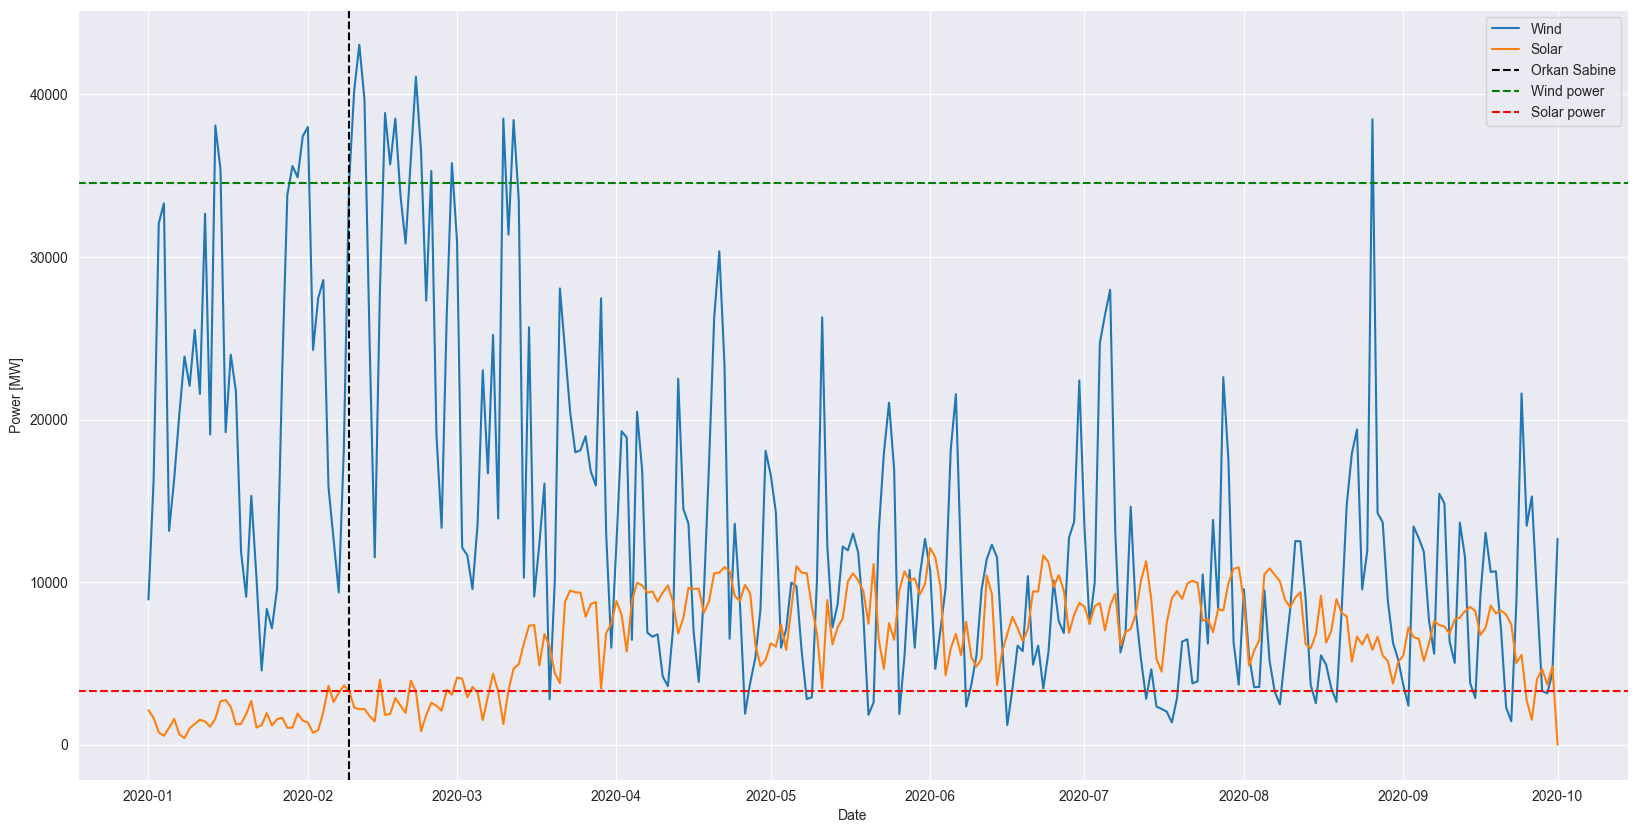

In [25]:
# Make local copies of the dataframes
local_power_df = power_df.copy()

# Prepare dataframe
orkan_sabine_date = pd.Timestamp(2020, 2, 9).date()

# Convert the "cet_cest_timestamp" column to a datetime object if it's not already
local_power_df["cet_cest_timestamp"] = pd.to_datetime(local_power_df["cet_cest_timestamp"])

# Print the power on the day of the storm for wind and solar
wind_power = local_power_df[local_power_df["cet_cest_timestamp"].dt.date == orkan_sabine_date]["DE_wind_generation_actual"].sum()
solar_power = local_power_df[local_power_df["cet_cest_timestamp"].dt.date == orkan_sabine_date]["DE_solar_generation_actual"].sum()
print("Wind power: {} MW".format(wind_power))
print("Solar power: {} MW".format(solar_power))

# Print the sum of both
print("Total power: {} MW".format(wind_power + solar_power))

# Graph visualisation of 2020 data with the storm
plt.figure(figsize=(20, 10))
plt.plot(local_power_df[local_power_df["cet_cest_timestamp"].dt.year == 2020]["cet_cest_timestamp"], local_power_df[local_power_df["cet_cest_timestamp"].dt.year == 2020]["DE_wind_generation_actual"], label="Wind")
plt.plot(local_power_df[local_power_df["cet_cest_timestamp"].dt.year == 2020]["cet_cest_timestamp"], local_power_df[local_power_df["cet_cest_timestamp"].dt.year == 2020]["DE_solar_generation_actual"], label="Solar")
plt.xlabel("Date")
plt.ylabel("Power [MW]")

# Create a vertical line for the storm
plt.axvline(orkan_sabine_date, color="black", linestyle="--", label="Orkan Sabine")

# Create a horizontal line for the power on the day of the storm
plt.axhline(local_power_df[local_power_df["cet_cest_timestamp"].dt.date == orkan_sabine_date]["DE_wind_generation_actual"].sum(), color="green", linestyle="--", label="Wind power")
plt.axhline(local_power_df[local_power_df["cet_cest_timestamp"].dt.date == orkan_sabine_date]["DE_solar_generation_actual"].sum(), color="red", linestyle="--", label="Solar power")

# Include a legend
plt.legend()
plt.show()

Another potential source for dips and surges in energy production are extreme weather conditions such as storms. The storm "Orkan Sabine" hit Germany on the 9th of February 2020 and caused havoc across the country. The storm caused a surge in wind energy production due to the massive amounts of wind and clouds. The total combined energy production on the day of the storm was 37866 MW. Solar production was not largely affected when compared to the norm production for this particular time of the year.

Both wind and solar energy production are heavily influenced by the weather. Wind energy production is proportional to wind speed and solar energy production is influenced by cloud cover. We can see this in the graphs above. This makes it difficult to predict exact energy production as weather forecasts are not always accurate. This is why grid providers need to be prepared for sudden changes in energy production making it a costly endeavour.

### Question 3. What is the potential for energy storage during peak production periods?

Energy storage is a very important topic in the energy sector. It allows us to store excess energy when it is produced and use it when it is needed. This is especially important for renewable energy sources, as they are not always available. For example, solar energy is only available during the day and wind energy is only available when it is windy. If we could store the energy produced during the day and use it at night, we would not need to rely on other energy sources such as coal or nuclear power as much. As current energy storage solutions aren't capable of storing large amounts of energy, we will focus on the potential for energy storage during peak production periods. Trend analysis and forecasting is used by grid providers to predict the amount of energy that will be produced in the future. This allows them to plan ahead and make sure that there is enough energy available for everyone. This is useful activating fossil power plants prematurely as these have a delayed response time compared to renewable energy sources.

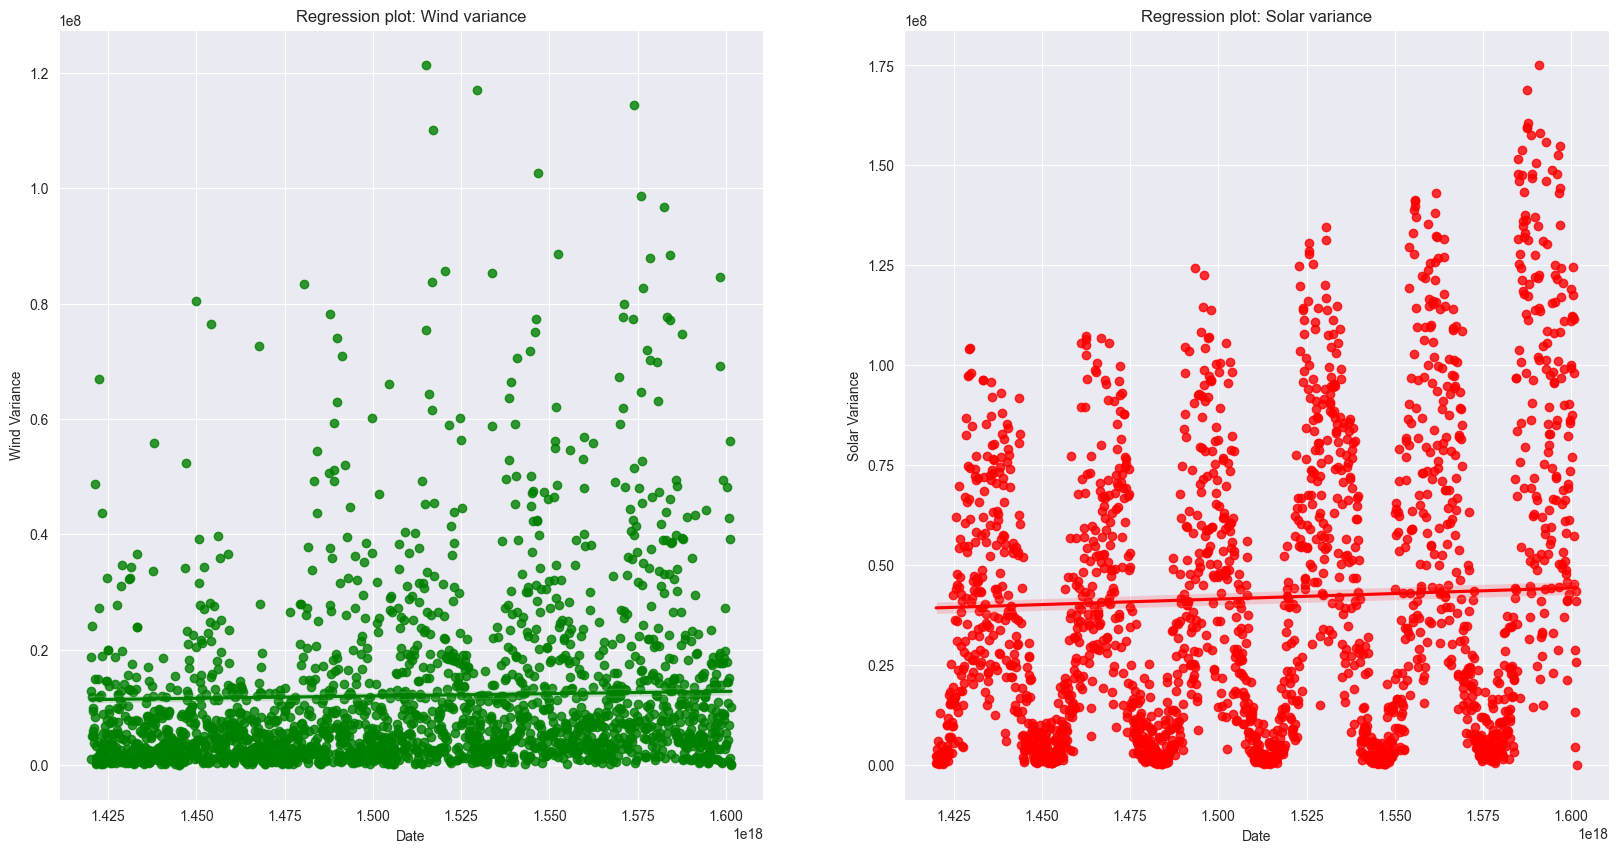

In [26]:
# We want to analyse the intra-day power generation variance for wind and solar. A high variance means that the power generation is not stable and that there is a lot of potential for energy storage.
intra_power_df = pd.read_sql_table("power_data", DATABASE_FILE)
intra_power_df["cet_cest_timestamp"] = pd.to_datetime(intra_power_df["cet_cest_timestamp"])
intra_power_df.set_index("cet_cest_timestamp", inplace=True)

# Calculate the variance for wind and solar generation
wind_variance = intra_power_df["DE_wind_generation_actual"].resample("D").var()
solar_variance = intra_power_df["DE_solar_generation_actual"].resample("D").var()

# Convert the datetime objects to numeric values (timestamp as int64) for regression analysis
wind_timeframe = wind_variance.index.astype(np.int64)
solar_timeframe = solar_variance.index.astype(np.int64)

# Combine time and wind variance into a dataframe and time and solar variance into another dataframe
wind_time_variance_df = pd.DataFrame({"Date": wind_timeframe, "Wind Variance": wind_variance.values})
solar_time_variance_df = pd.DataFrame({"Date": solar_timeframe, "Solar Variance": solar_variance.values})

# Plot two regression plots for wind and solar variance
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.regplot(x="Date", y="Wind Variance", data=wind_time_variance_df, color="green")
plt.title("Regression plot: Wind variance")
# todo: convert numeric values back to dates for x-axis

plt.subplot(1, 2, 2)
sns.regplot(x="Date", y="Solar Variance", data=solar_time_variance_df, color="red")
plt.title("Regression plot: Solar variance")
# todo: convert numeric values back to dates for x-axis

plt.show()

The regression plots above show the variance in wind and solar energy production over time. A high intra-day variance means that the energy production is not stable and that there is a lot of potential for energy storage as fossil power plants are already or need to be activated to compensate for the variance. Spikes of clean energy are lost without energy storage solutions.

The regression plots show that the variance for wind energy production is not increasing. This doesn't mean that energy production is stable but that there is a reliable but not increasing potential for energy storage. Due to little technical advancements in wind energy production, the variance is not increasing or decreasing over time.

On the other hand solar energy storage is evolving into a viable option. Due to the increased efficiency and decentralisation of solar energy production, the variance is increasing over time. This means that the energy production is becoming more unstable and that there might be more "lost energy" that could be stored.

### Question 4. What is the trend for renewable energy generation in Germany?

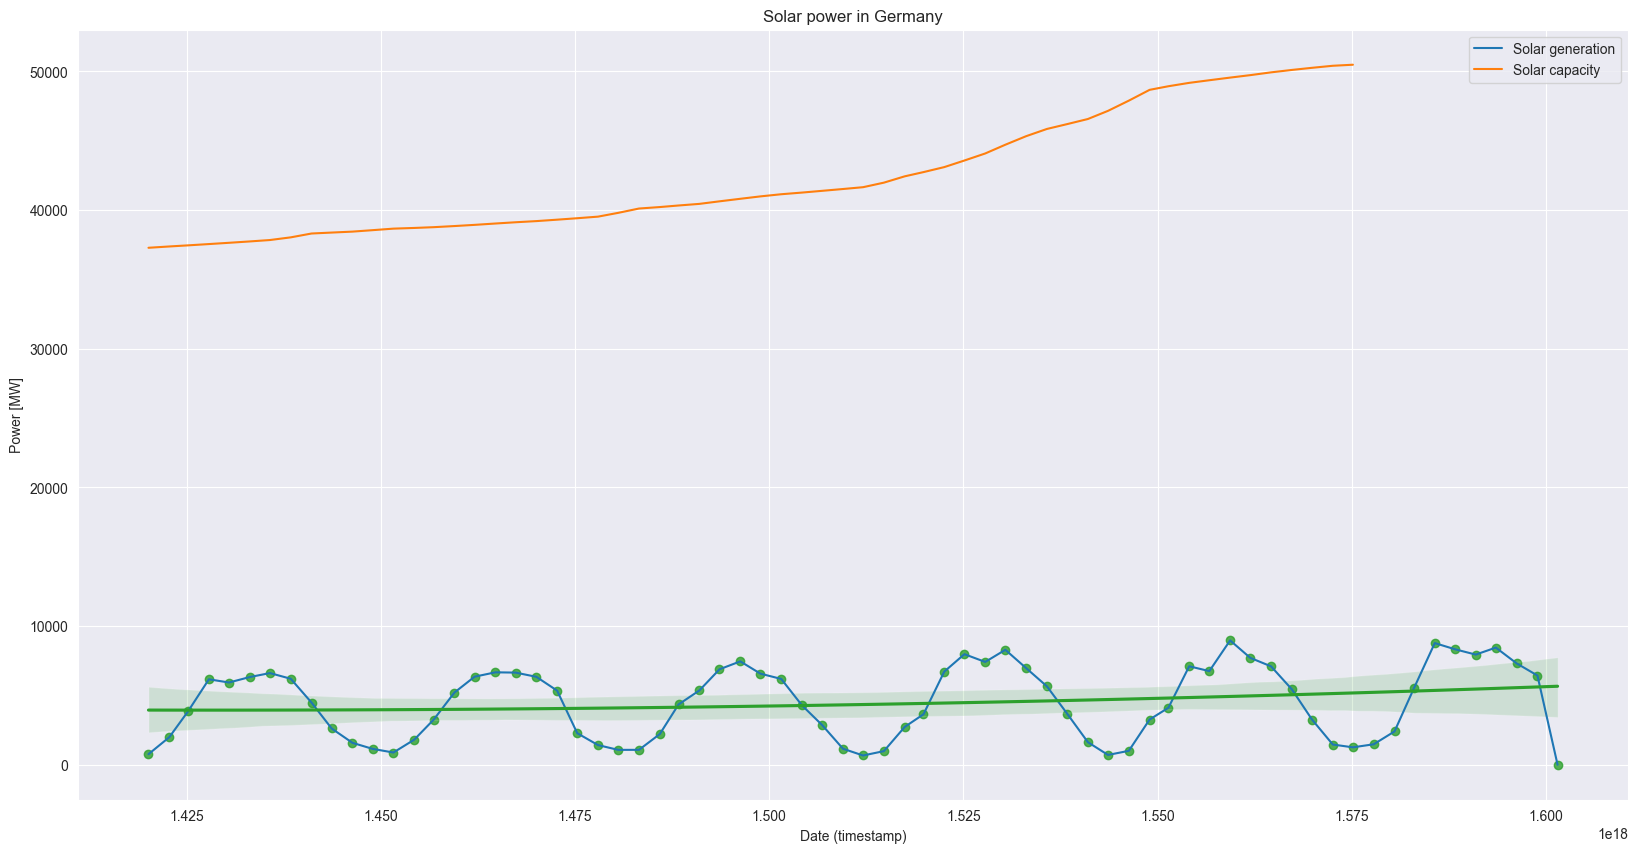

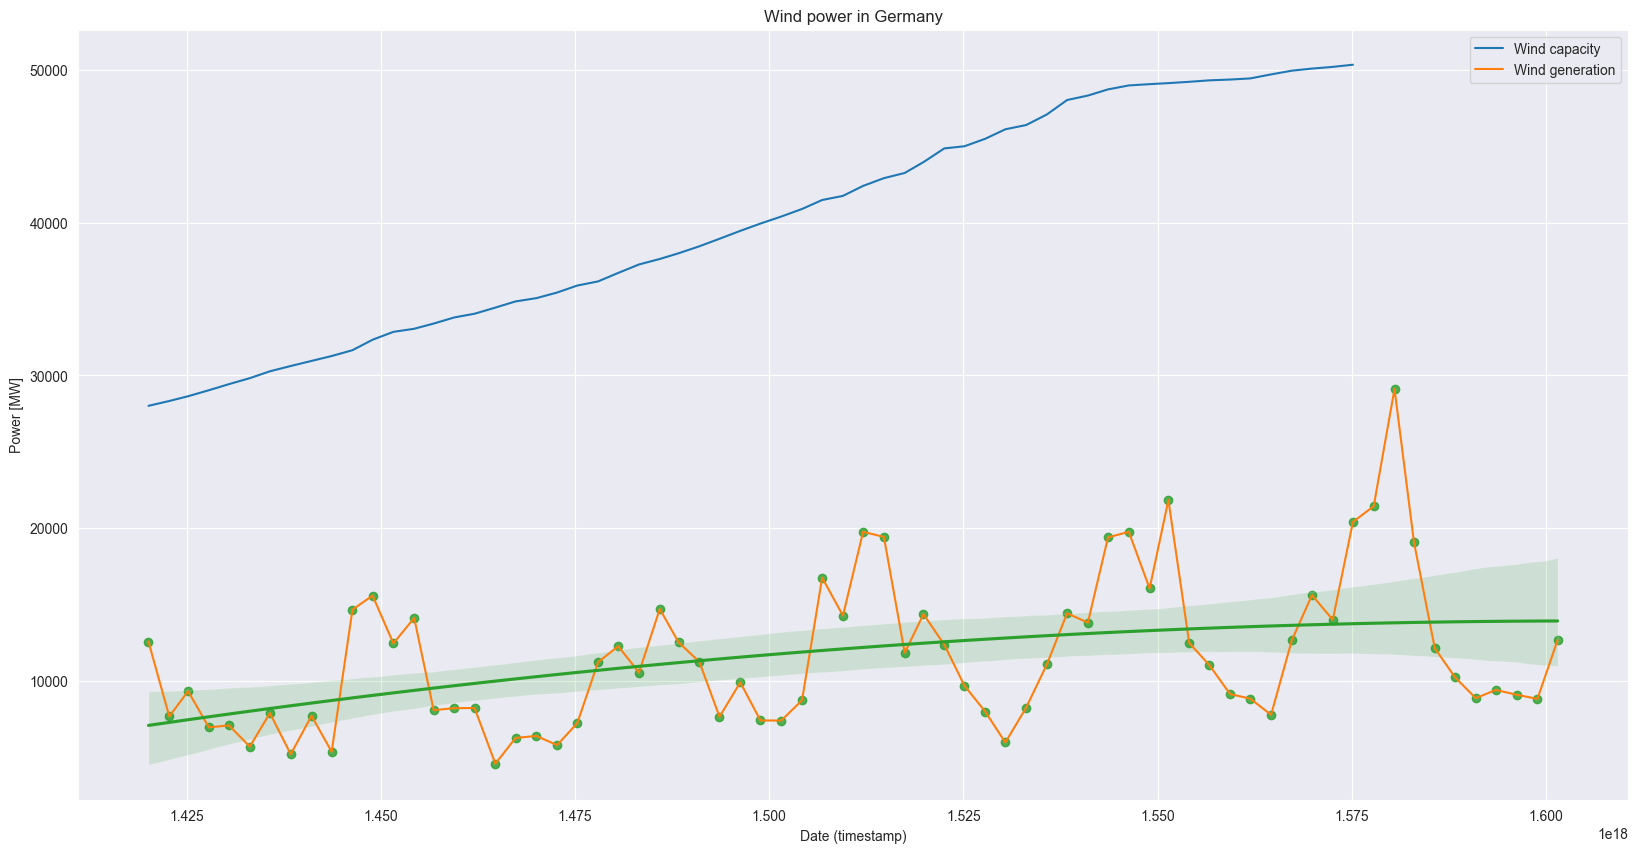

In [27]:
intra_power_df = pd.read_sql_table("power_data", DATABASE_FILE)
intra_power_df["cet_cest_timestamp"] = pd.to_datetime(intra_power_df["cet_cest_timestamp"])

# Only keep the year and month of the timestamp
intra_power_df["cet_cest_timestamp"] = intra_power_df["cet_cest_timestamp"].dt.to_period("M")

# Group the data by month and aggregate the mean value per month for wind and solar
intra_power_df = intra_power_df.groupby("cet_cest_timestamp").mean().reset_index()

# Convert the "cet_cest_timestamp" to a numeric value for regression analysis
intra_power_df["cet_cest_timestamp"] = intra_power_df["cet_cest_timestamp"].dt.to_timestamp().astype("int64")

# Plot the solar generation and capacity
plt.figure(figsize=(20, 10))
plt.plot(intra_power_df["cet_cest_timestamp"], intra_power_df["DE_solar_generation_actual"], label="Solar generation")
plt.plot(intra_power_df["cet_cest_timestamp"], intra_power_df["DE_solar_capacity"], label="Solar capacity")
sns.regplot(x="cet_cest_timestamp", y="DE_solar_generation_actual", data=intra_power_df, order=2)

plt.xlabel("Date (timestamp)")  # todo: convert numeric values back to dates for x-axis
plt.ylabel("Power [MW]")
plt.title("Solar power in Germany")
plt.legend()
plt.show()

# Plot the wind generation and capacity
plt.figure(figsize=(20, 10))
plt.plot(intra_power_df["cet_cest_timestamp"], intra_power_df["DE_wind_capacity"], label="Wind capacity")
plt.plot(intra_power_df["cet_cest_timestamp"], intra_power_df["DE_wind_generation_actual"], label="Wind generation")
sns.regplot(x="cet_cest_timestamp", y="DE_wind_generation_actual", data=intra_power_df, order=2)

plt.xlabel("Date (timestamp)")  # todo: convert numeric values back to dates for x-axis
plt.ylabel("Power [MW]")
plt.title("Wind power in Germany")
plt.legend()
plt.show()

The effectiveness and necessity of renewable energy in the climate crisis of the 21. century is undisputed. The question is how much renewable energy is produced and how much is needed to replace fossil fuels.

The trend for renewable energies in Germany isn't as clear as one might think. The solar energy production has only increased by a small amount over the last years (2015-2021) even though the solar energy capacity is accelerating its growth rapidly. Reasons for this are not part of this project but could be investigated in the future.

Good news is that wind production has more than doubled in the same timespan. The trend for wind energy production will continue to increase over the next years though there is a clear stagnation of growth after 2019. The reason for this stagnation is not part of this project but could be investigated in the future.

## 5. Conclusion

The analysis of the data shows a clear correlation of weather patterns affecting solar and wind energy production as well as growth of renewable energy sources in Germany. The trend for renewable energy production is increasing and will continue to increase over the next years. The need for energy storage will also grow with this expansion and diversification of renewable energy sources as the mix of decentralised energy production will make predicting energy production more difficult. Policies and regulations will have to be adapted to this new reality and political decisions will have to be made to convert our fossil fuel based energy system into a renewable energy system as well as ensure a reliable energy supply in the future.
